In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def import_data(experimental_file, response_file, response):
    'imports data'
    'experimental_file = experimental design csv filename i.e experimental.csv'
    'response_file = results csv filename i.e Response.csv'
    'response = reponse name: i.e rheomix final deg time min or rheomix stability time min'
    
    experimental_df = pd.read_csv(experimental_file)
    response_df = pd.read_csv(response_file)
    
    X = experimental_df[experimental_df.columns.values.tolist()[1:]].values
    y = response_df[response].values
    max1 = max(y)
    min1 = min(y)

    y_norm = [2*((i-min1)/(max1-min1)) - 1 for i in y]
    
    
    X_linear = X
    linear_terms = experimental_df.columns.values.tolist()[1:]
    
    return y_norm, X_linear, linear_terms, experimental_df, response_df
    

In [3]:
def X_gen(model, X_linear):

    for i, j in enumerate(model):
        
        if i == 0 and len(j) == 2: 
            X_new = X_linear[:, model[0][1]]
        
        else:
            
            if len(j) == 2:
                add = X_linear[:, j[1]]

            if len(j) == 3:
                add = X_linear[:, j[1]]*X_linear[:, j[2]]

            X_new2 = np.column_stack((X_new, add))
            X_new = X_new2

    
    return X_new

In [4]:
start = time.time()


# linear_terms = experimental_df.columns.values.tolist()[1:]



def fit_model(experimental_file, response_file, response):
    

    AIC_hist = []
    CN_hist = []
    AIC_hist1 = []
    CN_hist1 = []
    VIF_max_hist = []
    model_subset = []
    
    y, X_linear, linear_terms, experimental_df, response_df = import_data(experimental_file, response_file, response)
    lin_terms = []
    AIC_prev = 1000

    for i in range(len(linear_terms)):
        term = linear_terms[i]
        key = i
        lin_terms.append([term, i])

    cnt = 0
    for i in range(len(lin_terms)):
        for j in combinations(lin_terms, i+1):
            linear_terms = list(j)


            model = [a for a in linear_terms]
            cnt+=1

            X = X_gen(model, X_linear)

            model_fit = sm.OLS(y, X)
            results = model_fit.fit()
            AIC_cur = results.aic
            AIC_hist.append(AIC_cur)
            CN_hist.append(results.condition_number)
            
            
            if AIC_cur < 20:
                
                variables = model_fit.exog

                if variables.shape[1] != 1:
                    
                    vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
                    VIF_max_hist.append(max(vif))
                    AIC_hist1.append(AIC_cur)
                    CN_hist1.append(results.condition_number)

                    if AIC_cur < 20:
                        if results.condition_number < 600:
                            if max(vif) < 40:
                                model_subset.append([model, AIC_cur, results.condition_number, max(vif), results.rsquared])
                                
                    
                    
            if AIC_cur < AIC_prev:

                AIC_prev = AIC_cur
                final_model = [model, results, AIC_cur]
                




            poss_terms = []
            for i in range(len(linear_terms)):
                for j in range(len(linear_terms)): 
                    if i < j:
                        poss_terms.append([linear_terms[i][0] + '*' + linear_terms[j][0],  linear_terms[i][1], linear_terms[j][1]])



            for m in range(1, len(poss_terms) + 1):
                for k in combinations(poss_terms, m):

                    model = [a for a in linear_terms]
                    for i in range(m):
                        model.append(k[i])

                    cnt +=1
                    X = X_gen(model, X_linear)

                    model_fit = sm.OLS(y, X)
                    results = model_fit.fit()
                    AIC_cur = results.aic
                    
                    AIC_hist.append(AIC_cur)
                    CN_hist.append(results.condition_number)
                    
                    
                    if AIC_cur < 20:

                        variables = model_fit.exog

                        if variables.shape[1] != 1:

                            vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
                            VIF_max_hist.append(max(vif))
                            AIC_hist1.append(AIC_cur)
                            CN_hist1.append(results.condition_number)

                            
                            if AIC_cur < 20:
                                if results.condition_number < 600:
                                    if max(vif) < 40:
                                        model_subset.append([model, AIC_cur, results.condition_number, max(vif), results.rsquared])


                    if AIC_cur < AIC_prev:

                        AIC_prev = AIC_cur
                        final_model = [model, results, AIC_cur]




    return final_model[0], final_model[1], AIC_hist, CN_hist, VIF_max_hist, AIC_hist1, CN_hist1, model_subset


In [5]:
experimental_file = 'experimental.csv'
response_file = 'Response.csv'


test1 = 'rheomix final deg time min'
test2 = 'rheomix stability time min'
response = test1


model, results, AIC_hist, CN_hist, VIF_max_hist, AIC_hist1, CN_hist1, model_subset = fit_model(experimental_file, response_file, response)


In [6]:
model, results.summary()

([['Xpvc', 0],
  ['Xfiller', 1],
  ['Xfr', 2],
  ['Xstabiliser', 3],
  ['Xdinp', 4],
  ['Xldh', 5],
  ['Xfr*Xstabiliser', 2, 3],
  ['Xstabiliser*Xldh', 3, 5],
  ['Xdinp*Xldh', 4, 5]],
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.896
 Model:                            OLS   Adj. R-squared:                  0.871
 Method:                 Least Squares   F-statistic:                     35.40
 Date:                Wed, 11 Sep 2019   Prob (F-statistic):           1.60e-15
 Time:                        21:00:11   Log-Likelihood:                 2.2096
 No. Observations:                  46   AIC:                             13.58
 Df Residuals:                      37   BIC:                             30.04
 Df Model:                           9                                         
 Covariance Type:            nonrobust        

In [7]:
df = pd.DataFrame({'AIC total': AIC_hist, 'CN total':CN_hist})
df.to_csv("AIC_vs_CN_"  + response + ".csv")

In [8]:
df = pd.DataFrame({'AIC': AIC_hist1, 'CN':CN_hist1, 'VIF': VIF_max_hist})
df.to_csv("AIC_vs_CN_vs_VIF_"  + response + ".csv")

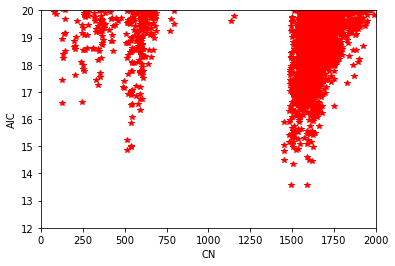

In [9]:
plt.plot(CN_hist, AIC_hist, 'r*')
plt.axis([0, 2000, 12, 20])
plt.xlabel('CN')
plt.ylabel('AIC')
plt.show()

In [10]:
# plt.plot(VIF_max_hist, AIC_hist1, 'r*')
# plt.show()

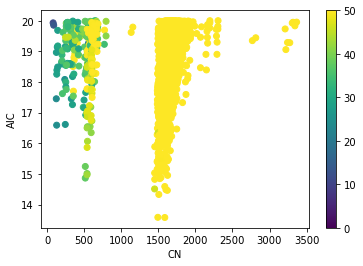

In [11]:
plt.scatter(CN_hist1, AIC_hist1, c = VIF_max_hist, vmin=0, vmax=50)
# plt.axis([0, 1000, 12, 20])
plt.xlabel('CN')
plt.ylabel('AIC')
plt.colorbar()
# plt.set_label('VIF')
plt.show()

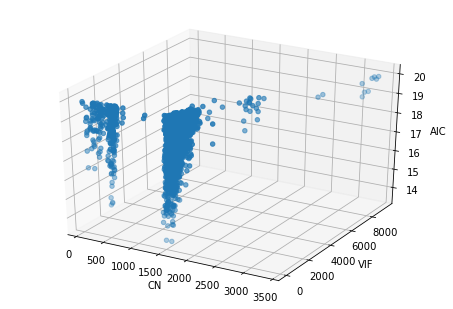

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(CN_hist1,VIF_max_hist, AIC_hist1)
plt.xlabel('CN')
plt.ylabel('VIF')
ax.set_zlabel('AIC')
# plt.axis([0, 1000, 12, 18])
# plt.colorbar()
plt.show()

In [13]:
len(model_subset)

105

In [15]:
for i in model_subset:
    if i[2] < 550 and i[2] > 450:
        a = []
        for j in i[0]:
            a.append(j[0])
        print('----model:', a, 'AIC', round(i[1], 3), 'CN:', round(i[2], 3), 'vif_max:', round(i[3], 3), 'R2:', round(i[4], 3), '----'
             )
        

----model: ['Xstabiliser', 'Xdinp', 'Xldh', 'Xstabiliser*Xdinp', 'Xstabiliser*Xldh', 'Xdinp*Xldh'] AIC 17.175 CN: 487.415 vif_max: 34.509 R2: 0.872 ----
----model: ['Xfiller', 'Xstabiliser', 'Xdinp', 'Xldh', 'Xstabiliser*Xldh', 'Xdinp*Xldh'] AIC 19.671 CN: 534.463 vif_max: 18.646 R2: 0.865 ----
----model: ['Xfr', 'Xstabiliser', 'Xdinp', 'Xldh', 'Xstabiliser*Xdinp', 'Xstabiliser*Xldh', 'Xdinp*Xldh'] AIC 18.247 CN: 512.367 vif_max: 35.39 R2: 0.874 ----
----model: ['Xfr', 'Xstabiliser', 'Xdinp', 'Xldh', 'Xfr*Xldh', 'Xstabiliser*Xdinp', 'Xstabiliser*Xldh', 'Xdinp*Xldh'] AIC 19.981 CN: 512.395 vif_max: 38.265 R2: 0.875 ----
----model: ['Xstabiliser', 'Xdinp', 'Xldh', 'Xsph', 'Xstabiliser*Xdinp', 'Xstabiliser*Xldh', 'Xdinp*Xldh'] AIC 19.141 CN: 505.203 vif_max: 37.289 R2: 0.872 ----
----model: ['Xstabiliser', 'Xdinp', 'Xldh', 'Xsph', 'Xstabiliser*Xldh', 'Xdinp*Xldh', 'Xdinp*Xsph'] AIC 17.411 CN: 497.592 vif_max: 29.064 R2: 0.877 ----
----model: ['Xstabiliser', 'Xdinp', 'Xldh', 'Xsph', 'Xstab